In [1]:
import numpy as np
from alive_progress import alive_bar
import time
from math import sqrt, pi, exp
import functools
import scipy
from varname import nameof
import os

# import algorithms (ULA, ALDI, NRALDI)
from utils.algorithms import * 
# import mog functions (density etc)
from utils.mog_functions import *
# import plot functions
from utils.plot_functions import *


## Test case "Mixture of Gaussians"  

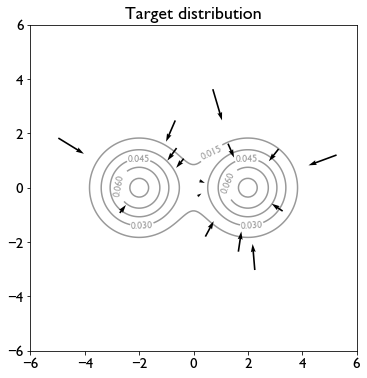

In [2]:
# dimension
d = 2


# parameters of the mixture 

sigma1, sigma2, gap = 1, 1, 4


# define (unnormalized) target density, potential, score (gradient log density)

target_unnorm_density = (lambda z : bimodal_distribution(z, gap, sigma1, sigma2))
target_potential = (lambda z: -np.log(target_unnorm_density(z)))
gradient_log_target = (lambda z: gradient_of_log_bimodal_distribution(z,  gap, sigma1, sigma2))

# plot posterior

val = 6
xmin, xmax, ymin, ymax = -val, val, -val, val
nb_grid = 200
u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U0, U1 = np.meshgrid(u0s,u1s) # each of the Ui's is of size (200, 200) (all X coordinates of points parallel to Y axis and reverse)
U = np.dstack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = target_unnorm_density(U) 

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z 
marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

fig, ax = plt.subplots(figsize = (10, 6))

DS = plt.contour(U0, U1, np.exp(-target_potential(U)), 5, alpha=0.4, colors="black")
plt.clabel(DS, inline=1, fontsize=10) # level sets of target


num_particles = 15
particles = np.random.normal(0, 2, size=(num_particles, d))
grad_particles = np.zeros_like(particles)
for i in range(num_particles):
        grad_particles[i] +=  gradient_log_target(particles[i,:])


x_pos = particles[:, 0]
y_pos = particles[:, 1]
x_direct = grad_particles[:, 0]
y_direct = grad_particles[:, 1]

ax.quiver(x_pos, y_pos, x_direct, y_direct, width = 0.005)
ax.set_title('Target distribution')
ax.set_aspect('equal')

## Try algorithms on one experiment

In [3]:
# parameters of all the algorithms

J = 20  # number of particles 
tau = 1e-2 # step size

# parameter of our algorithm (ALDINR)
const = 1.5


|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 14.8s (67.52/s▄▆ 61/1000 [6%] in 1s (~15s, 63.6/s)


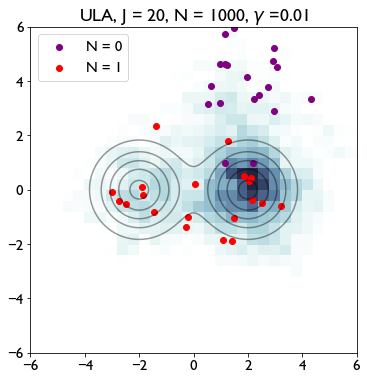

|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 15.2s (65.89/s


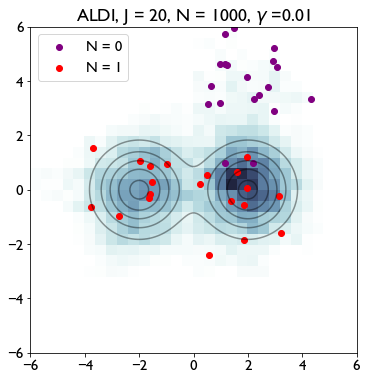

on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.9632577473385233                                                        


on 0: /Users/annakorba/Desktop/nreks/utils/algorithms.py:141: ComplexWarning: Casting complex values to real discards the imaginary part
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


on 500: iter                                                                    
on 500: 500                                                                     
on 500: lambda min                                                              
on 500: 0.9817398059750732                                                      
|████████████████████████████████████████⚠︎ (!) 999/1000 [100%] in 15.6s (64.09/s


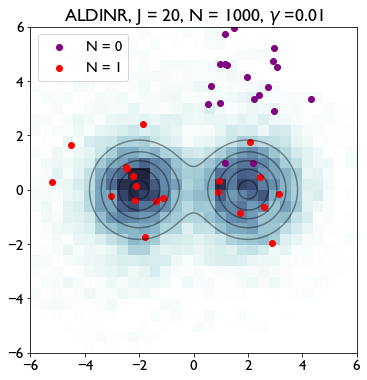

In [4]:
# number of iterations
N_sim = 1000

# number of experiments
N_exp = 1

# initialization parameters
mean_init = np.asarray([2,4])
cov_init = [[1, 0], [0, 2]]


for j in range(N_exp):
    
    # resample initialization
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    
    # ULA, ALDI and NRALDI with EXACT gradient formula (no approximation)
    us_list_ULA = run_ULA_mog(gradient_log_target, N_sim, u0, tau)
    name = nameof(us_list_ULA).lstrip('us_list')    
    plot_results(target_potential, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
   
    us_list_ALDI = run_ALDI_with_gradient_mog(gradient_log_target, N_sim, u0, tau)
    name = nameof(us_list_ALDI).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)

    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau, const) 
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)

    
    
    
    
    

    """
for j in range(N_exp):
    # same schemes with non-exact gradients : requires target density instead of grad log density
    print("Non exact gradients")
    us_list_ULA = run_ULA(target_potential, N_sim, u0, tau)
    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(target_potential, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
 
    us_list_ALDI = run_ALDI_with_gradient(target_potential, N_sim, u0, tau)
    name = nameof(us_list_ALDI).lstrip('us_list')  
    plot_results(target_potential, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
  
    us_list_ALDINR = run_ALDINR(target_potential, N_sim, u0, tau, const) 
    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
   """

### Important comment: it seems that for big step size (0.01), our scheme can crash when it's using non exact gradient. However, when it's using the exact gradient of the MOG density, it never crashes (see the cell below if you wanna test). Update: it can crash also with exact gradient when the gap between modes is zero.

In [5]:
"""
N_sim = 1000
N_exp = 3

for j in range(N_exp):
    
    # resample initialization
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
 
    # NRALDI with exact gradients
    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau, const) 
   
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
"""

"\nN_sim = 1000\nN_exp = 3\n\nfor j in range(N_exp):\n    \n    # resample initialization\n    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T\n \n    # NRALDI with exact gradients\n    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau, const) \n   \n    name = nameof(us_list_ALDINR).lstrip('us_list')    \n    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)\n"

## Plot some statistics for each scheme 

In [7]:
# compute means and covariances

means_ULA, covariances_ULA = compute_means(us_list_ULA), compute_covariances(us_list_ULA)
means_ALDI, covariances_ALDI = compute_means(us_list_ALDI), compute_covariances(us_list_ALDI)
means_ALDINR, covariances_ALDINR = compute_means(us_list_ALDINR), compute_covariances(us_list_ALDINR)

Text(0.5, 1.0, '$\\Vert \\bar{u}_n - u^*\\Vert$')

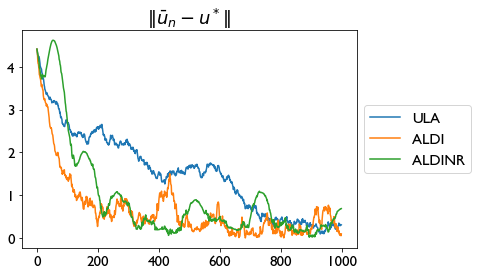

In [23]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'$\Vert \bar{u}_n - u^*\Vert$')

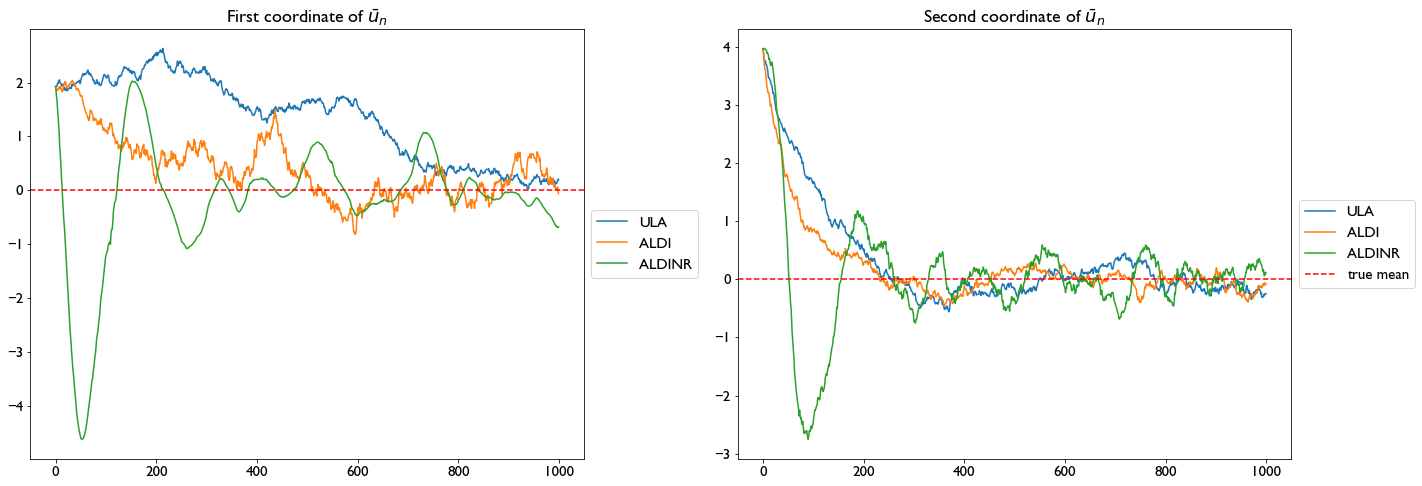

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('First coordinate of '+ r'$\bar{u}_n$')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Second coordinate of '+ r'$\bar{u}_n$')
plt.tight_layout()

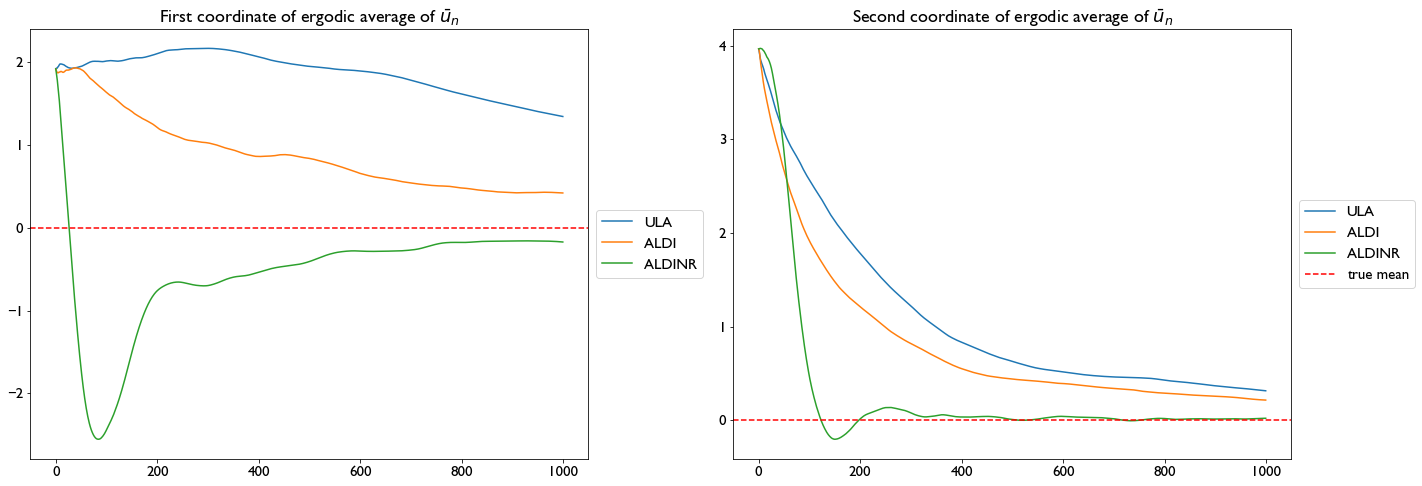

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

# ergodic average
average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('First coordinate of ergodic average of '+ r'$\bar{u}_n$')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Second coordinate of ergodic average of '+ r'$\bar{u}_n$')
plt.tight_layout()

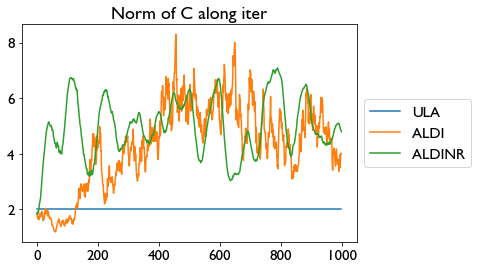

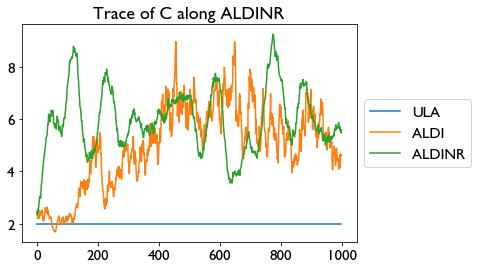

In [27]:

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')
plt.show()

traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
plt.show()

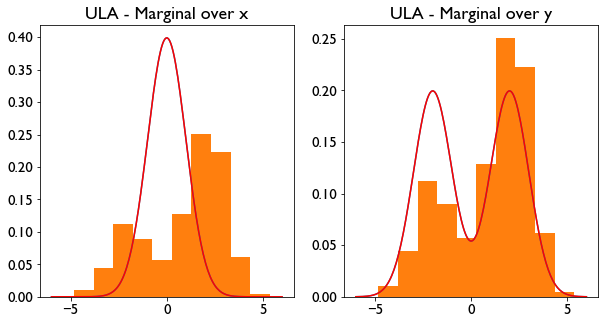

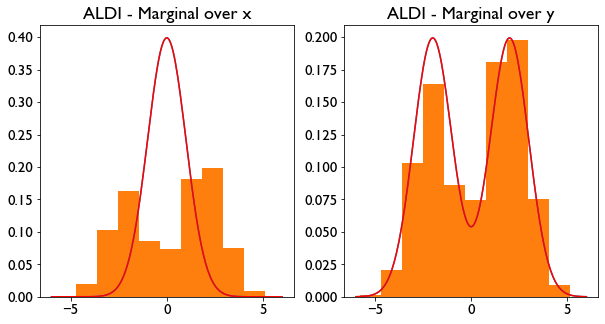

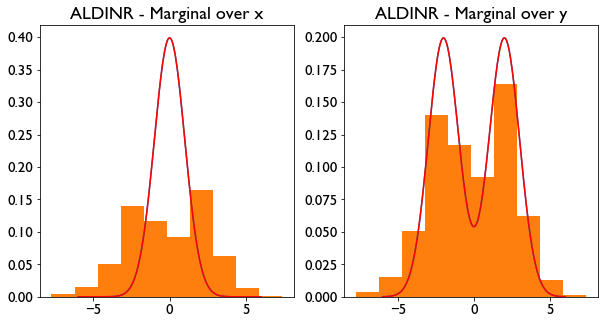

In [28]:
# Plot marginals

plot_marginals_histogram(us_list_ULA, target_unnorm_density, 'ULA')
plot_marginals_histogram(us_list_ALDI, target_unnorm_density, 'ALDI')
plot_marginals_histogram(us_list_ALDINR, target_unnorm_density, 'ALDINR')


## Run many experiments to average results 

In [80]:

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 10 # number of iterations #### TO CHANGE
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 

N_exp = 5


file_experiment = 'save_data/mog/'

for j in range(N_exp):
    
    print()
    print("Experiment "+str(j))
    
    # resample initialization
    mean_init = np.asarray([2,4])
    cov_init = [[1, 0], [0, 2]]
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    #print(u0.shape)   #np.random.normal(0,1.0,(d,J)) 

    # ULA
    us_list_ULA = run_ULA_mog(gradient_log_target, N_sim, u0, tau)
    if not os.path.isdir(file_experiment+'/ULA'):
       os.makedirs(file_experiment+'/ULA')
    np.save('save_data/mog/ULA/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    # ALDI 
    if not os.path.isdir(file_experiment+'/ALDI'):
       os.makedirs(file_experiment+'/ALDI')
    us_list_ALDI = run_ALDI_with_gradient_mog(gradient_log_target, N_sim, u0, tau)
    np.save('save_data/mog/ALDI/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    
    # NRALDI 
    if not os.path.isdir(file_experiment+'/ALDINR'):
       os.makedirs(file_experiment+'/ALDINR')
    tau_ALDINR = tau
    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)
    



Experiment 0
(2, 20)
|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (49.79/s)     
|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (56.52/s)     
on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.7608159838697781                                                        


on 0: /Users/annakorba/Desktop/nreks/utils/algorithms.py:141: ComplexWarning: Casting complex values to real discards the imaginary part
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (43.99/s)     

Experiment 1
(2, 20)
|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (57.50/s)     
|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (49.63/s)     
on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 1.1007985238125988                                                        
|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (51.54/s)     7/10 [70%] in 0s (~0s, 54.7/s) 

Experiment 2
(2, 20)
|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (51.34/s)     
|████████████████████████████████████⚠︎   | (!) 9/10 [90%] in 0.2s (50.19/s)     
on 0: iter                                                                      
on 0: 0                     

## Compute some statistics over a bunch of random experiments

In [89]:

#const = 1.5

# Choose the experiment (Mixture of Gaussian with some gap and with some initialization)
toy_case = 'save_data/mog_gap_4_sigma_1_badinit/'


# Number of experiments for the toy case (on which results are averaged)
N_exp = 0
for root_dir, cur_dir, files in os.walk(toy_case +'ALDINR/'):
    N_exp += len(files)
print('Number of experiments:', N_exp)

# dimension, number of particles, number of iterations
name_first_file = os.listdir(toy_case +'ALDINR/')[0]
first_experiment_iterates = np.load(toy_case +'ALDINR/' + name_first_file)
d, J, N_sim = first_experiment_iterates.shape



Number of experiments: 47
2 20 1000


In [101]:
# Create some statistics for experiments




# particles means and covariances at each time iteration and for each experiment

means_ULA_all  = np.zeros((d, N_sim, N_exp))
means_ALDI_all = np.zeros((d, N_sim, N_exp))
means_ALDINR_all = np.zeros((d, N_sim, N_exp))

covariances_ULA_all = np.zeros((d, d, N_sim, N_exp))
covariances_ALDI_all = np.zeros((d, d, N_sim, N_exp))
covariances_ALDINR_all = np.zeros((d, d, N_sim, N_exp))


for j in range(N_exp):

    # load data from experiment j
    us_list_ULA = np.load(toy_case + 'ULA/ULA_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')
    us_list_ALDI = np.load(toy_case + 'ALDI/ALDI_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')    
    us_list_ALDINR = np.load(toy_case +'ALDINR/ALDINR_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy')
    
    #my_file = toy_case +'/ALDINR_J_20_Nsim_1000_tau_0.01_Exp_'+str(j)+'.npy'
    #const = re.findall(re.escape('c_')+"(.*)"+re.escape('_J'),my_file)[0]

    # compute means and covariances (at all iterations) over J particles for each experiment j
    
    means_ULA_all[:, :, j] = np.mean(us_list_ULA, axis = 1)
    means_ALDI_all[:, :, j] = np.mean(us_list_ALDI, axis = 1)
    means_ALDINR_all[:, :, j] = np.mean(us_list_ALDINR, axis = 1)

    covariances_ULA_all[:, :, :, j] = compute_covariances(us_list_ULA)
    covariances_ALDI_all[:, :, :, j] = compute_covariances(us_list_ALDI)
    covariances_ALDINR_all[:, :, :, j] = compute_covariances(us_list_ALDINR)

# means_algo_all = means(experiments_iterates)

# average over N_exp of the means of particles) - vectors of size (d, N_sim)

means_ULA_over_exp, std_ULA_over_exp = np.mean(means_ULA_all, axis = 2), np.std(means_ULA_all, axis = 2)
means_ALDI_over_exp, std_ALDI_over_exp = np.mean(means_ALDI_all, axis = 2), np.std(means_ALDI_all, axis = 2)
means_ALDINR_over_exp, std_ALDINR_over_exp = np.mean(means_ALDINR_all, axis = 2), np.std(means_ALDINR_all, axis = 2)


# here: put std

#plt.plot(range(N_sim), means_ULA_over_exp[0, :], label = 'ULA' )
#error =  np.asarray(np.std(means_ULA_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
#error_ax1 =  error[0, :] # shape (1, 3000)
#plt.fill_between(range(N_sim), means_ULA_over_exp[0, :] - error_ax1, means_ULA_over_exp[0, :] + error_ax1, alpha=0.2)


# average over N_exp of the covariances of the particles - vectors of size (d, d, N_sim)

covariances_ULA_over_exp = np.mean(covariances_ULA_all, axis = 3)
covariances_ALDI_over_exp = np.mean(covariances_ALDI_all, axis = 3)
covariances_ALDINR_over_exp = np.mean(covariances_ALDINR_all, axis = 3)


In [ ]:
####### PLOTs

def plot_norm_means(means_algo_over_exp):
    
    norm_means = np.linalg.norm(means_algo_over_exp, axis=0)
    plt.plot(norm_means, label = 'algo' )

    # plot distances to target mean
    
    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    fig.set_figheight(5)
    fig.set_figwidth(20)

    plt.subplot(1, 2, 1)
    
    norm_means = np.linalg.norm(means_algo_over_exp, axis=0)
    plt.plot(norm_means, label = 'algo' )
    
    #distances_to_mean_ULA = np.linalg.norm(means_ULA_over_exp, axis=0)
    #plt.plot(distances_to_mean_ULA, label = 'ULA' )

    #distances_to_mean_ALDI = np.linalg.norm(means_ALDI_over_exp, axis=0)
    #plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

    #distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR_over_exp, axis=0)
    #plt.plot(distances_to_mean_ALDINR, label = 'ALDINR') 

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Norm of unbarre (J = '+str(J)+', $\gamma$ = '+str(tau)+')')

    # plot norm of covariances

    plt.subplot(1, 2, 2)
    distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA_over_exp[:, :, i]) for i in range(covariances_ULA.shape[2])])
    plt.plot(distances_to_covariances_ULA, label ='ULA')

    #distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI_over_exp[:, :, i]) for i in range(covariances_ALDI.shape[2])])
    #plt.plot(distances_to_covariances_ALDI, label ='ALDI')

    #distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR_over_exp[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
    #plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Norm of covariance (J = '+str(J)+', $\gamma$ = '+str(tau)+')')
    plt.tight_layout()
    
plot_norm_means(means_ULA_over_exp)


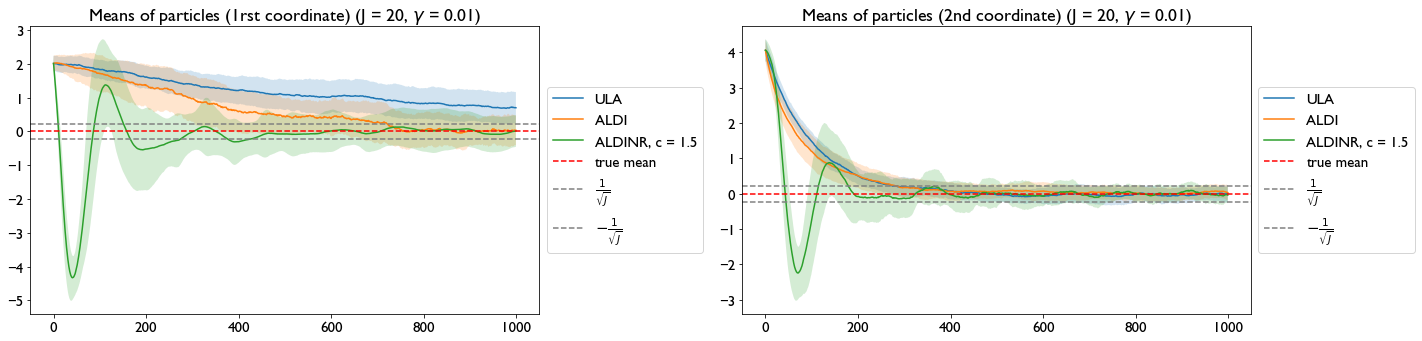

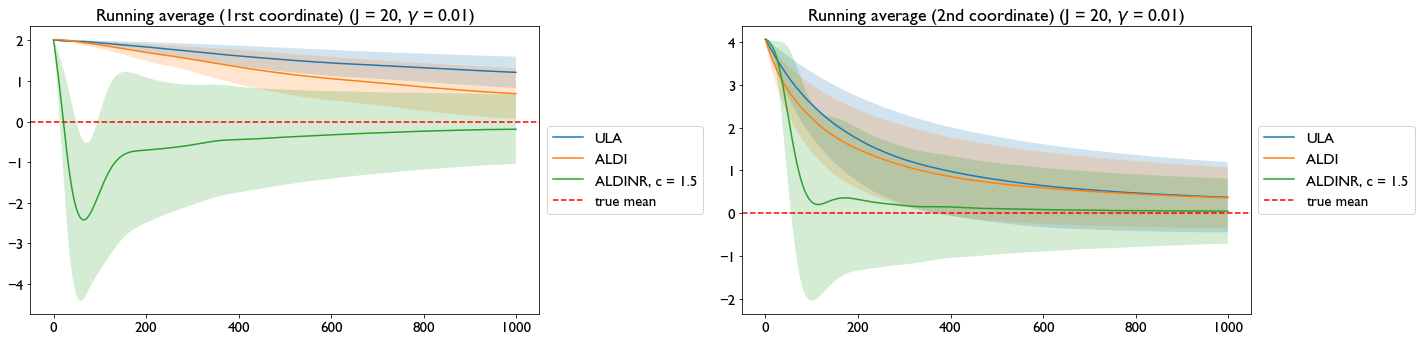

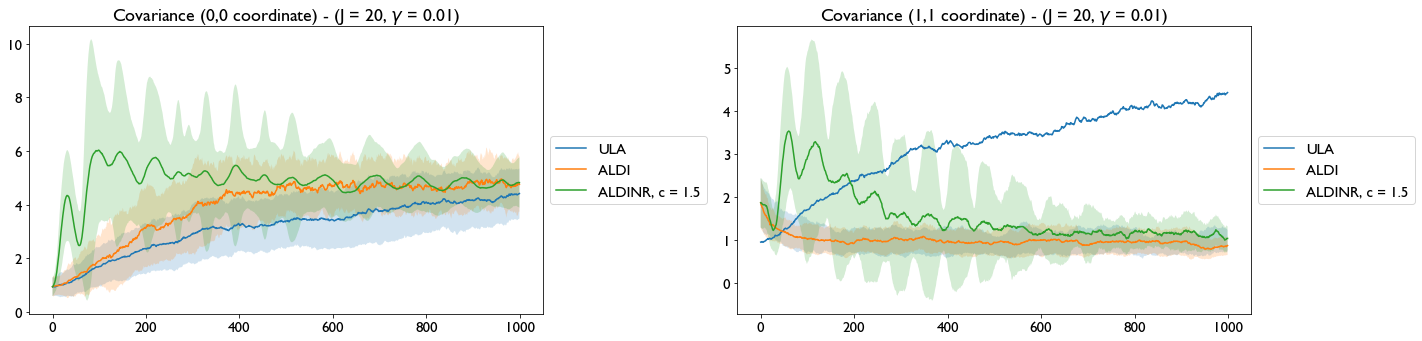

In [94]:


#### PLOTS


# plot norm of mean and covariance


# plot means of particles along iterations


# plot running average

#  plot covariance estimate coordinate by coordinate (4 coordinates)





# plot means coordinates


fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_figheight(5)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(range(N_sim), means_ULA_over_exp[0, :], label = 'ULA' )
error =  np.asarray(np.std(means_ULA_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ULA_over_exp[0, :] - error_ax1, means_ULA_over_exp[0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), means_ALDI_over_exp[0, :], label = 'ALDI' )
error =  np.asarray(np.std(means_ALDI_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDI_over_exp[0, :] - error_ax1, means_ALDI_over_exp[0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), means_ALDINR_over_exp[0, :], label = 'ALDINR, c = '+str(const))
error =  np.asarray(np.std(means_ALDINR_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDINR_over_exp[0, :] - error_ax1, means_ALDINR_over_exp[0, :] + error_ax1, alpha=0.2)

plt.axhline(y = 0, color='r', linestyle='--', label ='true mean')
plt.axhline(y = 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
plt.axhline(y = -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (1rst coordinate) (J = '+str(J)+', $\gamma$ = '+str(tau)+')')


plt.subplot(1, 2, 2)
plt.plot(range(N_sim), means_ULA_over_exp[1, :], label = 'ULA' )
error =  np.asarray(np.std(means_ULA_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ULA_over_exp[1, :] - error_ax1, means_ULA_over_exp[1, :] + error_ax1, alpha=0.2)

plt.plot(means_ALDI_over_exp[1, :], label = 'ALDI' )
error =  np.asarray(np.std(means_ALDI_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDI_over_exp[1, :] - error_ax1, means_ALDI_over_exp[1, :] + error_ax1, alpha=0.2)

plt.plot(means_ALDINR_over_exp[1, :], label = 'ALDINR, c = '+str(const))
error =  np.asarray(np.std(means_ALDINR_all, axis = 2)) # shape (d, N_sim) = (2, 3000)
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), means_ALDINR_over_exp[1, :] - error_ax1, means_ALDINR_over_exp[1, :] + error_ax1, alpha=0.2)

plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.axhline(y = 1/np.sqrt(J), color='gray', linestyle='--', label = r'$\frac{1}{\sqrt{J}}$')
plt.axhline(y = -1/np.sqrt(J), color='gray', linestyle='--', label = r'$ - \frac{1}{\sqrt{J}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate) (J = '+str(J)+', $\gamma$ = '+str(tau)+')')
plt.tight_layout()







fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_figheight(5)
fig.set_figwidth(20)

average_means_ULA = np.asarray([np.mean(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(range(N_sim), average_means_ULA[:, 0], label = 'ULA' )
error =  np.asarray([np.std(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ULA[:, 0] - error_ax1, average_means_ULA[:, 0] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDI[:, 0], label = 'ALDI' )
error =  np.asarray([np.std(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDI[:, 0] - error_ax1, average_means_ALDI[:, 0] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDINR[:, 0], label = 'ALDINR, c = '+str(const))
error =  np.asarray([np.std(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[0, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDINR[:, 0] - error_ax1, average_means_ALDINR[:, 0] + error_ax1, alpha=0.2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Running average (1rst coordinate) (J = '+str(J)+', $\gamma$ = '+str(tau)+')')

plt.subplot(1, 2, 2)
plt.plot(range(N_sim), average_means_ULA[:, 1], label = 'ULA' )
error =  np.asarray([np.std(means_ULA_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ULA[:, 1] - error_ax1, average_means_ULA[:, 1] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDI[:, 1], label = 'ALDI' )
error =  np.asarray([np.std(means_ALDI_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDI[:, 1] - error_ax1, average_means_ALDI[:, 1] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), average_means_ALDINR[:, 1], label = 'ALDINR, c = '+str(const))
error =  np.asarray([np.std(means_ALDINR_over_exp[:, :i], axis = 1) for i in range(1, N_sim + 1)]).T
error_ax1 =  error[1, :] # shape (1, 3000)
plt.fill_between(range(N_sim), average_means_ALDINR[:, 1] - error_ax1, average_means_ALDINR[:, 1] + error_ax1, alpha=0.2)

plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Running average (2nd coordinate) (J = '+str(J)+', $\gamma$ = '+str(tau)+')')
plt.tight_layout()





fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_figheight(5)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(range(N_sim), covariances_ULA_over_exp[0, 0, :], label = 'ULA' )
error =  np.std(covariances_ULA_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[0, 0, :]
plt.fill_between(range(N_sim), covariances_ULA_over_exp[0, 0, :] - error_ax1, covariances_ULA_over_exp[0, 0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDI_over_exp[0, 0, :], label = 'ALDI' )
error =  np.std(covariances_ALDI_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[0, 0, :]
plt.fill_between(range(N_sim), covariances_ALDI_over_exp[0, 0, :] - error_ax1, covariances_ALDI_over_exp[0, 0, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDINR_over_exp[0, 0, :], label = 'ALDINR, c = '+str(const) )
error =  np.std(covariances_ALDINR_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[0, 0, :]
plt.fill_between(range(N_sim), covariances_ALDINR_over_exp[0, 0, :] - error_ax1, covariances_ALDINR_over_exp[0, 0, :] + error_ax1, alpha=0.2)

#plt.axhline(y = 0.6, color='r', linestyle='--', label ='K[0,0]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covariance (0,0 coordinate) - (J = '+str(J)+', $\gamma$ = '+str(tau)+')')

plt.subplot(1, 2, 2)

plt.plot(range(N_sim), covariances_ULA_over_exp[0, 0, :], label = 'ULA' )
error =  np.std(covariances_ULA_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[1, 1, :]
plt.fill_between(range(N_sim), covariances_ULA_over_exp[1, 1, :] - error_ax1, covariances_ULA_over_exp[1, 1, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDI_over_exp[1, 1, :], label = 'ALDI' )
error =  np.std(covariances_ALDI_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[1, 1, :]
plt.fill_between(range(N_sim), covariances_ALDI_over_exp[1, 1, :] - error_ax1, covariances_ALDI_over_exp[1, 1, :] + error_ax1, alpha=0.2)

plt.plot(range(N_sim), covariances_ALDINR_over_exp[1, 1, :], label = 'ALDINR, c = '+str(const) )
error =  np.std(covariances_ALDINR_all, axis = 3) # shape (d, d, N_sim) = (2, 2, 3000)
error_ax1 =  error[1, 1, :]
plt.fill_between(range(N_sim), covariances_ALDINR_over_exp[1, 1, :] - error_ax1, covariances_ALDINR_over_exp[1, 1, :] + error_ax1, alpha=0.2)

#plt.axhline(y = 0.6, color='r', linestyle='--', label ='K[1,1]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Covariance (1,1 coordinate) - (J = '+str(J)+', $\gamma$ = '+str(tau)+')')
plt.tight_layout()
#plt.savefig('MOG_example_statistics_ALDINR_c_'+str(const)+'.pdf')
plt.show()
